# Scraping Data from Deutscher Wetterdienst (DWD)
CDC = Climate Data Center

We are only going to look at the **recent** data provided by DWD, which includes the last 500 days until yesterday.

## Hints
- _product file_ = the file that contains the data we are looking for, in this case the recent hourly measurements of temperature and humidity of _one_ station
- _quality_ = quality level of the data assigned by DWD (1 - worst, 10 - best)





In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from zipfile import ZipFile
import os
import datetime
import shutil

In [2]:
DIR_hourly_recent = "raw_data/hourly/temperature/recent/"
DIR_hourly_historical = "raw_data/hourly/temperature/historical/"

DIR_export = "processed_data/hourly/temperature/"

In [3]:
URL_hourly_recent = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/"
URL_hourly_historical = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/"

URL_stations_recent = URL_hourly_recent + "TU_Stundenwerte_Beschreibung_Stationen.txt"
URL_stations_historical = URL_hourly_historical + "TU_Stundenwerte_Beschreibung_Stationen.txt"

## Load the list of weather stations

In [4]:
def parse_weather_station_info(text):
    text = text.splitlines()
    data = []
    for line in text[2:]:
        e = line.split()
        station_id = e.pop(0)
        start_date = e.pop(0)
        end_date = e.pop(0)
        altitude = e.pop(0)
        latitude = e.pop(0)
        longitude = e.pop(0)
        state = e.pop(-1)
        station_name = " ".join(e)

        row = [station_id, start_date, end_date, altitude, latitude, longitude, station_name, state]
        data.append(row)

    columns = ["station_id", "start_date", "end_date", "altitude", "latitude", "longitude", "name", "state"]
    df = pd.DataFrame(data, columns=columns)
    
    # convert columns to numeric 
    df = df.apply(pd.to_numeric, errors="ignore")
    
    # convert dates into datetime objects
    df[["start_date", "end_date"]] = df[["start_date", "end_date"]].apply(pd.to_datetime, format="%Y%m%d")
    
    return df



# historical data
req = requests.get(URL_stations_historical)
text = req.text
stations_hist = parse_weather_station_info(text)
stations_hist.to_csv(DIR_export + "/historical/stations_historical.csv")
stations_hist

# recent data
req = requests.get(URL_stations_recent)
text = req.text
stations_rec = parse_weather_station_info(text)
stations_rec.to_csv(DIR_export + "/recent/stations_historical.csv")
stations_rec

,station_id,start_date,end_date,altitude,latitude,longitude,name,state
0,3,1950-04-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,44,2007-04-01,2020-03-27,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,52,1976-01-01,1988-01-01,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,71,2009-12-01,2020-01-02,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
4,73,2007-04-01,2020-03-27,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern
...,...,...,...,...,...,...,...,...
653,14138,2009-09-15,2015-12-31,73,52.1655,14.1224,Falkenberg (Grenzschichtmessfeld),Brandenburg
654,15000,2011-04-01,2020-03-27,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
655,15207,2013-11-01,2020-03-27,317,51.2835,9.3590,Schauenburg-Elgershausen,Hessen
656,15444,2014-09-01,2020-03-27,593,48.4418,9.9216,Ulm-Mähringen,Baden-Württemberg


## Scrape all zip links that are available

In [5]:
def scrape_product_links(soup):
    anchors = soup.find_all("a")
    links = []
    
    for a in anchors:
        ref = a.get("href")
        if ref.startswith("stundenwerte_TU_") and ref.endswith(".zip"):
            links.append(ref)
    return links


# historical
req = requests.get(URL_hourly_historical)
soup = BeautifulSoup(req.content, "html.parser")
historical_urls = scrape_product_links(soup)


# recent
req = requests.get(URL_hourly_recent)
soup = BeautifulSoup(req.content, "html.parser")
recent_urls = scrape_product_links(soup)
  

## Download all zip files

In [18]:
def download_all_product_files(DIR_source, file_urls, DIR_destination):
    total = len(file_urls)
    print(f"Downloading {total} files to {DIR_destination}")
    
    for i, url in enumerate(file_urls, start=1):
        req = requests.get(DIR_source + url)

        with open(DIR_destination + url, "wb") as file:
            file.write(req.content)
            
        # unzip the file and only keep the extracted content
        with ZipFile(DIR_destination + url, "r") as zippy:
            dirname = DIR_destination + url[:-4]
            if os.path.isdir(dirname):
                shutil.rmtree(dirname)
            try:
                os.mkdir(dirname)
                zippy.extractall(dirname)
                os.remove(DIR_destination + url)
            except Exception as e:
                print(e)
        
        if i % 50 == 0 or i == total:
            print("%d of %d files downloaded" % (i , total))
            
            
# recent data            
download_all_product_files(URL_hourly_historical, historical_urls, DIR_hourly_historical) 

# recent data            
download_all_product_files(URL_hourly_recent, recent_urls, DIR_hourly_recent)

50 of 618 files downloaded
100 of 618 files downloaded
150 of 618 files downloaded
200 of 618 files downloaded
250 of 618 files downloaded
300 of 618 files downloaded
350 of 618 files downloaded
400 of 618 files downloaded
450 of 618 files downloaded
500 of 618 files downloaded
550 of 618 files downloaded
600 of 618 files downloaded
618 of 618 files downloaded
50 of 508 files downloaded
100 of 508 files downloaded
150 of 508 files downloaded
200 of 508 files downloaded
250 of 508 files downloaded
300 of 508 files downloaded
350 of 508 files downloaded
400 of 508 files downloaded
450 of 508 files downloaded
500 of 508 files downloaded
508 of 508 files downloaded


## Extract temperature und humidity data from all station data
Now, for every available weather station there exists a folder containing measurement as well as meta data about the corresponding station.

### Get all directories that were downloaded

In [6]:
def get_directories(path, prefix, suffix):
    dir_list = []

    dir_iter = os.scandir(path)
    for i in dir_iter:
        if i.is_dir():
            name = i.name
            if name.startswith(prefix) and name.endswith(suffix):
                dir_list.append(name + "/")
    return dir_list



                
                
recent_folders = get_directories(DIR_hourly_recent, "stundenwerte_", "_akt")
historical_folders = get_directories(DIR_hourly_historical, "stundenwerte_", "_hist")

### Product file data extraction
Extract the data provided in one product file (i.e. hourly recent temperature + humidity for station-id)

In [7]:
# get all files that were contained in the zip and find the product file
def get_files(path, prefix, suffix, exactly_one=False):
    file_list = []

    dir_iter = os.scandir(path)
    for i in dir_iter:
        if i.is_file():
            name = i.name
            if name.startswith(prefix) and name.endswith(suffix):
                file_list.append(name)
    
    if exactly_one is True:
        if len(file_list) == 1:
            return file_list[0]
        elif len(file_list) > 1:
            raise Exception("There seem to exist two product files for the same station!")
        else:
            raise Exception("No product file found!")
    else:
        return file_list


# extract the data from the text file
def product_file_to_dataframe(file_path):
    text = None
    with open(file_path, "r") as file:
        text = file.read().splitlines()


    data = []
    for line in text[1:]:
        row = line.split(";")
        values = [value.strip() for value in row]
        values.pop()
        data.append(values)

    colnames = ["station_id", "date", "quality", "temperature", "humidity"]
    df = pd.DataFrame(data, columns=colnames)
    return df



In [25]:
# test for one file
dirname = DIR_hourly_recent + "stundenwerte_TU_00073_akt/"
product_name = get_files(dirname, "produkt_tu_stunde_", ".txt", exactly_one=True)


product_path = dirname + product_name
df = product_file_to_dataframe(product_path)
df

,station_id,date,quality,temperature,humidity
0,73,2018092400,3,10.3,88.0
1,73,2018092401,3,9.9,89.0
2,73,2018092402,3,9.1,93.0
3,73,2018092403,3,8.7,91.0
4,73,2018092404,3,8.0,93.0
...,...,...,...,...,...
13195,73,2020032619,1,6.4,48.0
13196,73,2020032620,1,6.0,50.0
13197,73,2020032621,1,5.7,52.0
13198,73,2020032622,1,6.0,50.0


### Iterate over all downloaded directories and collect the data

In [8]:
def directories_to_dataframe(DIR_root, dir_list):
    frames = []
    for folder_name in dir_list:
        path = DIR_root + folder_name
        # find product file name
        product_file = get_files(path, "produkt_tu_stunde_", ".txt", exactly_one=True)
        product_file = path + product_file
        # extract the data from this file
        df = product_file_to_dataframe(product_file)

        frames.append(df)

    # concatenate all the frames into one frame
    return pd.concat(frames)

df_rec = directories_to_dataframe(DIR_hourly_recent, recent_folders)
df_hist = directories_to_dataframe(DIR_hourly_historical, historical_folders)
df_hist

,station_id,date,quality,temperature,humidity
0,131,2004110101,10,9.4,100.0
1,131,2004110102,10,9.3,100.0
2,131,2004110103,10,9.3,100.0
3,131,2004110104,10,9.1,100.0
4,131,2004110105,10,8.9,100.0
...,...,...,...,...,...
307989,554,2006022720,3,1.9,87.0
307990,554,2006022721,3,1.8,88.0
307991,554,2006022722,3,0.8,94.0
307992,554,2006022723,3,0.5,96.0


### Data Cleaning
- convert columns into numerical values
- convert date column into datetime format
- remove error entries

In [10]:
def clean_data(df):
    df = df.apply(pd.to_numeric)
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d%H")

    df.loc[df["temperature"] == -999, "temperature"] = float("NaN")
    df.loc[df["humidity"] == -999, "humidity"] = float("NaN")
    return df

df_r = clean_data(df_rec)
df_h = clean_data(df_hist)

In [14]:
df_h.sample(10)

,station_id,date,quality,temperature,humidity
160512,430,2004-04-24 02:00:00,10,6.8,93.0
43591,6105,2009-04-22 01:00:00,3,4.2,96.0
367102,1544,1996-08-24 12:00:00,10,20.8,76.0
44736,5133,2009-10-11 18:00:00,3,10.6,87.0
127150,6197,2016-08-10 06:00:00,3,10.0,89.0
267817,5705,1978-07-21 02:00:00,5,11.3,88.0
43448,596,1977-12-16 09:00:00,5,0.8,98.0
24474,3509,2007-07-17 19:00:00,3,22.2,60.0
525708,656,2008-01-13 13:00:00,3,2.1,71.0
135360,175,1970-06-11 01:00:00,5,15.9,97.0


## Checkpoint

Save as csv

In [ ]:
df_r.to_csv(DIR_export + "recent_cleaned.csv", index=False)
df_h.to_csv(DIR_export + "historical_cleaned.csv", index=False)

In [7]:
# reload data
df_rec = pd.read_csv(DIR_export + "recent_cleaned.csv")
df_hist = pd.read_csv(DIR_export + "historical_cleaned.csv")

# format as datetime
df_rec["date"] = pd.to_datetime(df_rec["date"])
df_hist["date"] = pd.to_datetime(df_hist["date"])

In [8]:
df_hist

,station_id,date,quality,temperature,humidity
0,131,2004-11-01 01:00:00,10,9.4,100.0
1,131,2004-11-01 02:00:00,10,9.3,100.0
2,131,2004-11-01 03:00:00,10,9.3,100.0
3,131,2004-11-01 04:00:00,10,9.1,100.0
4,131,2004-11-01 05:00:00,10,8.9,100.0
...,...,...,...,...,...
124846785,554,2006-02-27 20:00:00,3,1.9,87.0
124846786,554,2006-02-27 21:00:00,3,1.8,88.0
124846787,554,2006-02-27 22:00:00,3,0.8,94.0
124846788,554,2006-02-27 23:00:00,3,0.5,96.0


In [9]:
#df_hist.groupby(["station_id"]).mean().sort_values("temperature", ascending=False)
df_rec.sort_values("humidity", ascending=False)

,station_id,date,quality,temperature,humidity
2233822,5426,2020-01-02 09:00:00,3,-1.7,100.0
3671193,3147,2019-11-27 09:00:00,3,3.8,100.0
2276916,7330,2018-11-23 23:00:00,3,-2.9,100.0
3671179,3147,2019-11-26 19:00:00,3,4.1,100.0
3671180,3147,2019-11-26 20:00:00,3,3.7,100.0
...,...,...,...,...,...
6525759,161,2019-10-22 04:00:00,3,NaN,NaN
6525760,161,2019-10-22 05:00:00,3,NaN,NaN
6525761,161,2019-10-22 06:00:00,3,NaN,NaN
6525762,161,2019-10-22 07:00:00,3,NaN,NaN


### Merge recent and historical data
If data overlaps, I want the data with the highest quality level to be kept

In [13]:
# stack recent and historical dataframe
df = pd.concat([df_hist, df_rec], ignore_index=True)
# sort duplicate rows descending by quality
df.sort_values(by=["station_id", "date", "quality"], ascending=False, inßplace=True)
# drop duplicate rows, keeping the first
df.drop_duplicates(["station_id", "date"], keep='first', inplace=True)

In [25]:
# export to csv
df.to_csv(DIR_export + "temperatures.csv", index=False)

## Summarize Data

For the interactive plot, I want:
- Slider shows data per year
- color = max/min/average temperature of that year
- size = # similar days / percentile?
- opacity = ?

In [71]:
summary_all = df.groupby(pd.Grouper(key='date', freq='Y')).describe()
summary_stations = df.groupby([df["station_id"], pd.Grouper(key='date', freq='Y')]).describe()

In [72]:
# save as csv
summary_stations.to_csv(DIR_export + "temperatures_summary.csv", index=False)

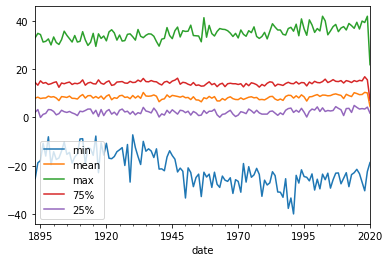

In [60]:
summary_all["temperature"][["min", "mean", "max", "75%", "25%"]].plot()

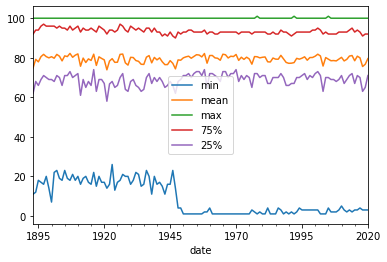

In [61]:
summary_all["humidity"][["min", "mean", "max", "75%", "25%"]].plot()